# Architecture of Camera Radar Fusion Tracking
![Architecture of Camera Radar Fusion Tracking](../media/architecture_of_camerar_radar_tracking.png)

In [501]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import RadarPointCloud, view_points
from pyquaternion import Quaternion
from sklearn.cluster import DBSCAN
from PIL import Image

from sort import Sort

In [384]:
# instance of sort
mot_tracker = Sort() 

In [385]:
!ls | grep jpg

n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg
n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg
n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604512404.jpg
n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605012404.jpg


In [386]:
# read image
im1 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg')
im2 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg')
im3 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604512404.jpg')
im4 = Image.open('n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605012404.jpg')


In [117]:
!ls | grep .pcd

n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151603555991.pcd
n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604069888.pcd
n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604579949.pcd
n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151605015872.pcd


In [392]:
pc1 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151603555991.pcd')
pc2 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604069888.pcd')
pc3 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151604579949.pcd')
pc4 = RadarPointCloud.from_file('n008-2018-08-01-15-16-36-0400__RADAR_FRONT__1533151605015872.pcd')


In [393]:
type(pc1)

nuscenes.utils.data_classes.RadarPointCloud

In [115]:
def calibrate_radar_points(pc: RadarPointCloud) -> tuple[np.ndarray, np.ndarray]:
    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    # cs_record = self.nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    cs_record = {'token': 'f4d2a6c281f34a7eb8bb033d82321f79', 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a', 'translation': [3.412, 0.0, 0.5], 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088], 'camera_intrinsic': []}
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    # poserecord = self.nusc.get('ego_pose', pointsensor['ego_pose_token'])
    poserecord1 = {'token': 'b70cefb08263499eb30c7e7da0031428', 'timestamp': 1532402928114656, 'rotation': [0.5742482223921863, -0.00183950588546914, 0.014160690493351492, -0.8185566994058888], 'translation': [409.8439847252494, 1176.9519903782593, 0.0]}
    pc.rotate(Quaternion(poserecord1['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord1['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    # poserecord = self.nusc.get('ego_pose', cam['ego_pose_token'])
    poserecord2 = {'token': '4b6870ae200c4b969b91c50a9737f712', 'timestamp': 1532402928112460, 'rotation': [0.5742377826385253, -0.0018667925555496464, 0.014165885989800115, -0.8185638715152707], 'translation': [409.8506686425138, 1176.9702106041582, 0.0]}
    pc.translate(-np.array(poserecord2['translation']))
    pc.rotate(Quaternion(poserecord2['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    # cs_record = self.nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    cs_record = {'token': '1d31c729b073425e8e0202c5c6e66ee1', 'sensor_token': '725903f5b62f56118f4094b46a4470d8', 'translation': [1.70079118954, 0.0159456324149, 1.51095763913], 'rotation': [0.4998015430569128, -0.5030316162024876, 0.4997798114386805, -0.49737083824542755], 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984], [0.0, 1266.417203046554, 491.50706579294757], [0.0, 0.0, 1.0]]}
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]
    print('depth', depths)
    # retreive the color from depth
    coloring = depths

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points_with_depth = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=False)
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    print(points.shape)
    print(points_with_depth.shape)
    # for i in range(10):
    #     print('x: ', int(points.T[i][0]), ' y: ', int(points.T[i][1]), ' z: ', int(points.T[i][2]))

    print('-----')
    # for i in range(10):
    #     print('x: ', int(points_with_depth.T[i][0]), ' y: ', int(points_with_depth.T[i][1]), ' z: ', int(points_with_depth.T[i][2]))


    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    min_dist : float = 1.0
    dot_size : int = 5
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im1.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im1.size[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]
    return points, coloring

In [450]:
pc2.points.shape

(114, 3)

In [454]:
cleaned_data.T.shape

(3, 114)

In [452]:
pc3.points.shape

(18, 76)

In [455]:
pc5 = pc2
pc5.points = cleaned_data.T
points5, coloring5 = calibrate_radar_points(pc5)

depth [ 15.22792338 -12.40037525   7.46506927   6.63565563   6.03359146
  11.23217719  10.61425546  -6.39183441  10.80873935  12.6121736
   9.20323429  -9.59594919  -7.01251296 -13.40764412   8.17428461
  13.1783874    9.3708291  -11.82351168  -4.83734785 -12.23591849
 -14.23590495 -14.03659594  -4.25183023   7.31982414   8.31981738
   7.91706271  13.11564843   4.09985227  -5.90421668  -4.70905107
  18.47838178  18.86734767  19.66182789  18.25149616  10.22666845
  11.61424869   9.00599359  -7.39596428 -12.80626893 -13.00902514
 -13.80833048   8.97565826 -11.81799616  12.37425599  -4.83596897
 -13.03729215  15.14045471  15.53700442  17.3383713    7.72533704
   8.72257252   8.11775059  16.31562658  16.90941795  -6.299388
  17.0901121   18.88665196  18.08114263  18.47562403  19.87078809
  16.06392019  18.86045327  18.84597505  10.23701004  10.43425074
  10.43080354  11.81493753   7.00324937  12.01079936   8.39979232
  12.20597173 -12.40144594  -5.61528057 -11.42144645  15.16389564
  16.96

In [429]:
points1, coloring1 = calibrate_radar_points(pc1)
points2, coloring2 = calibrate_radar_points(pc2)
points3, coloring3 = calibrate_radar_points(pc3)
points4, coloring4 = calibrate_radar_points(pc4)

depth [ 25.79101652  26.84432022  24.0454634    7.73960841  22.19448923
  27.43974527  15.14124198   2.11067514  30.77158835   1.83830014
   1.06415766  23.22924278   2.78618325  26.56108604   9.23993329
   1.07773104 -11.47052313  25.18156532  31.36791657  13.97256261
  28.42653826  28.73013196   9.26617484  30.55079175  25.37385613
  20.68601902   3.95259967   0.62075564  21.60268325  18.55588333
  20.8783103   42.14347275  -4.17250262  -4.53762884  -9.96929526
  12.47495169  28.94776039  -8.33413886  29.37532625   6.14607751
 -12.87357249 -17.41979432 -15.46837511   6.60486224  -3.35356711
  29.05408594  10.36427118  30.74489171  36.29962507  29.80379603
  30.05173846  31.30909712  27.35830224  24.49112479  30.03997406
   7.67173924  17.81567422  29.65041415  26.87010779  29.80560613
  30.70371983]
(3, 61)
(3, 61)
-----
depth [17.27562186 17.51592015 18.00759203 19.60806655 18.65509235 18.06403172
 19.64401189 20.42435456 17.78636029 20.52570321 20.58010716 18.91603726
 20.6815316  

In [81]:
%matplotlib inline

In [195]:
points1[1, :]

array([655.09680387, 569.43893318, 563.34379555, 555.13610615,
       549.09139576, 545.05786902, 536.47490902, 539.38361938,
       534.5058903 , 536.78866564, 529.64069316, 534.65121264,
       529.28955569, 529.98096267, 527.06766047, 529.89679476,
       529.57992062, 525.86578863, 526.4172244 , 523.79030066,
       516.44808868, 519.57668692, 516.15308398, 516.18118702,
       517.29578082, 515.55514173, 517.38869804, 514.24249287,
       514.54861844, 515.39830592, 513.43510591, 514.1747252 ,
       513.50352933, 514.00135307, 513.92416095, 512.10103404,
       514.22026246, 512.95296883, 511.16468968, 512.79090857,
       512.79586027, 510.88063134, 510.4272333 , 513.79650387,
       511.4970395 , 509.73077349, 508.19260517, 509.14117401,
       507.01816907, 507.72858094, 506.18099868, 507.09315664,
       509.51523188, 505.93882355])

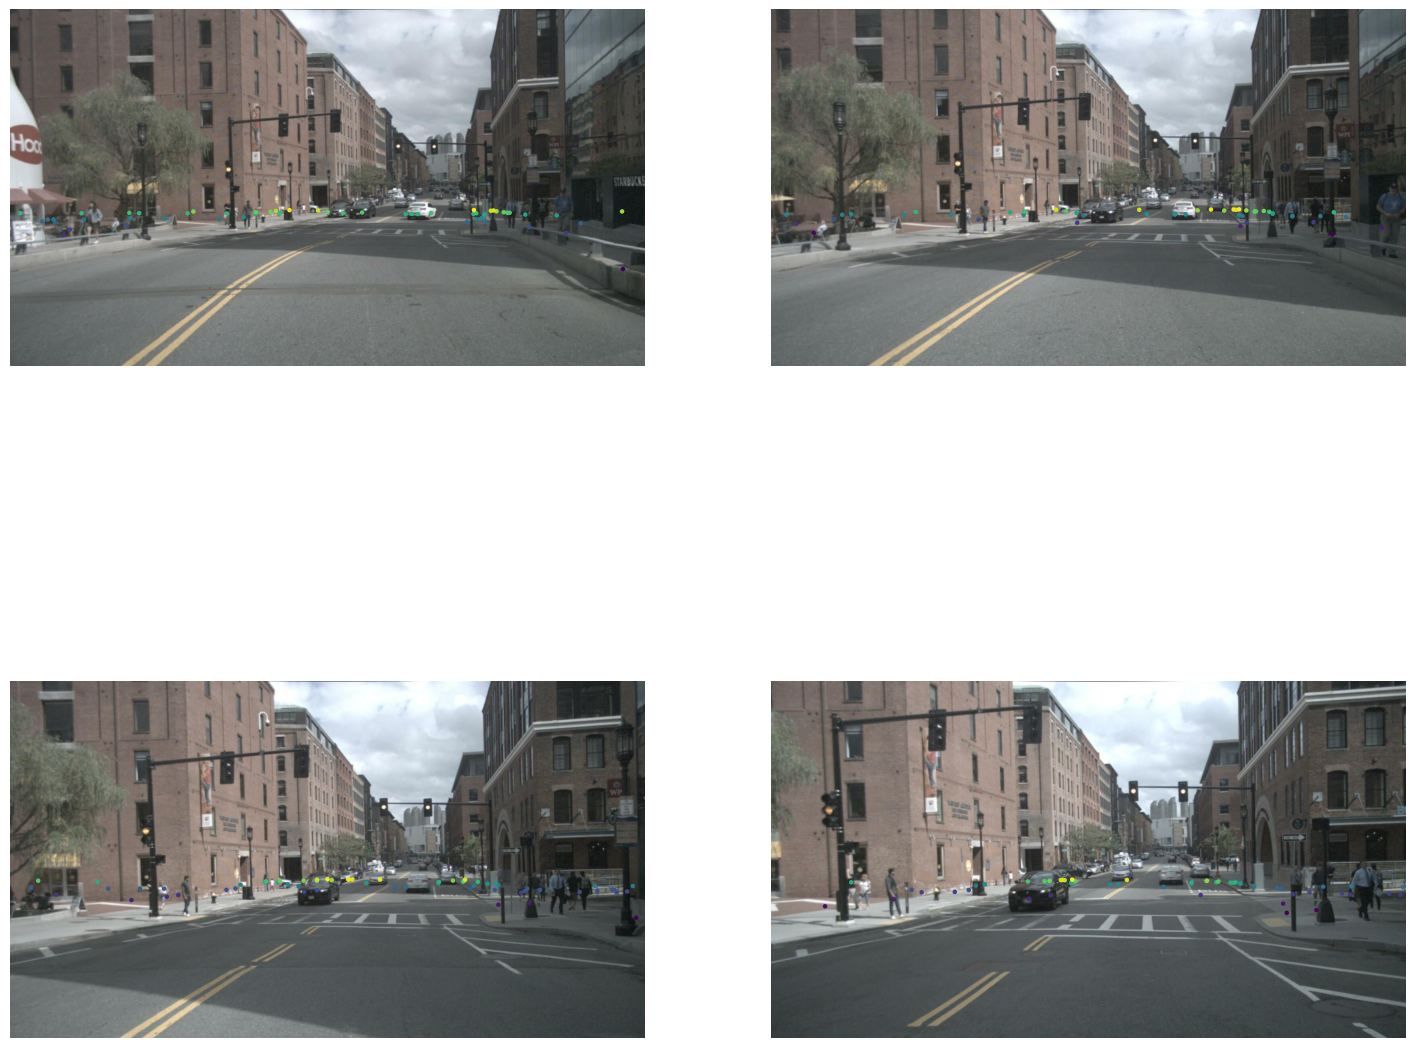

In [125]:
fig, ax = plt.subplots(2, 2, figsize=(18, 16))
# fig.canvas.set_window_title("sample token")
ax[0,0].imshow(im1)
ax[0,0].scatter(points1[0, :], points1[1, :], c=coloring1, s=5)
ax[0,0].axis('off')

ax[0,1].imshow(im2)
ax[0,1].scatter(points2[0, :], points2[1, :], c=coloring2, s=5)
ax[0,1].axis('off')

ax[1,0].imshow(im3)
ax[1,0].scatter(points3[0, :], points3[1, :], c=coloring3, s=5)
ax[1,0].axis('off')

ax[1,1].imshow(im4)
ax[1,1].scatter(cleaned_data[0, :], cleaned_data[1, :], c=cleaned_data[:,2], s=5)
ax[1,1].axis('off')



plt.show()

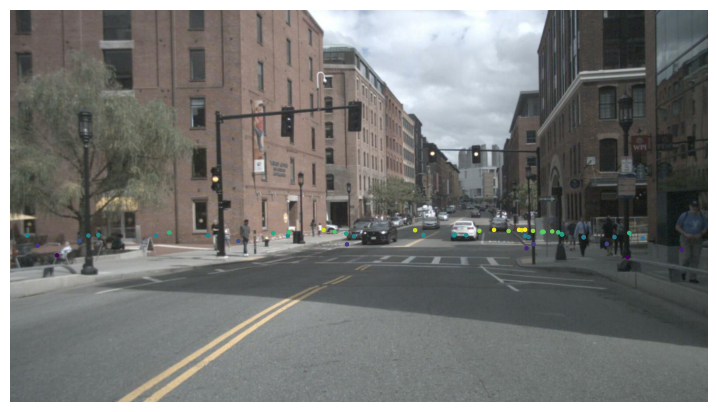

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
# fig.canvas.set_window_title("sample token")
ax.imshow(im2)
ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
ax.axis('off')
plt.show()

# Radar Clustering with DBScan

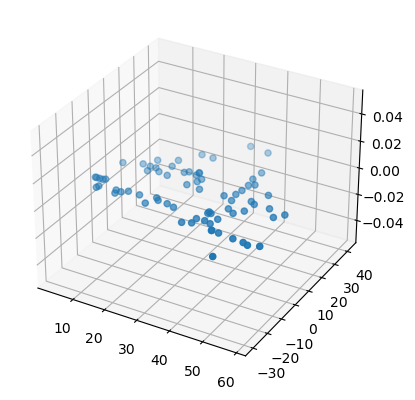

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pc.points[0, :], pc.points[1, :], pc.points[2, :])
plt.show()

In [62]:
db_scan = DBSCAN(eps=3, min_samples=1)

In [65]:
output = db_scan.fit(pc.points[0:3, :])

In [66]:
output.labels_

array([0, 1, 2])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pc.points[0, :], pc.points[1, :], pc.points[2, :])
plt.show()

In [21]:
points = pc.points[:3, :]

In [24]:
# prepare model
model = DBSCAN(eps=4, min_samples=2)

In [23]:
points = points.T
points.shape

(74, 3)

In [26]:
model.fit(points)

DBSCAN(eps=4, min_samples=2)

In [27]:
labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of nose points: %d" % n_noise_)

Estimated number of clusters: 14
Estimated number of nose points: 12


In [28]:
print(labels)

[ 0  0  0  0  0 -1  1  1  2  3  3  2  2  2  3  3  3  2 -1  3 -1  4 -1  4
  5 -1  5  5  4  5  5  5  5  4  5 -1  6  6  7  8  8  8  8  8  8  7  7  8
  9  7  8  8 10  9 10 10 11  8  8  9 11 -1  8 -1 -1 -1 12 13 -1 12 13 12
 -1 12]


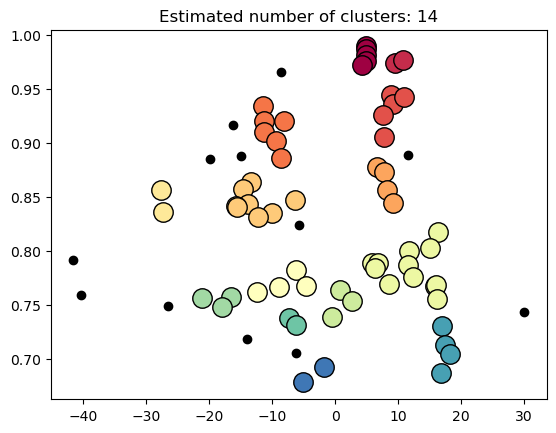

In [29]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = points[class_member_mask & core_samples_mask]

    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [140]:
# %matplotlib notebook
# !pip install ipympl
%matplotlib widget

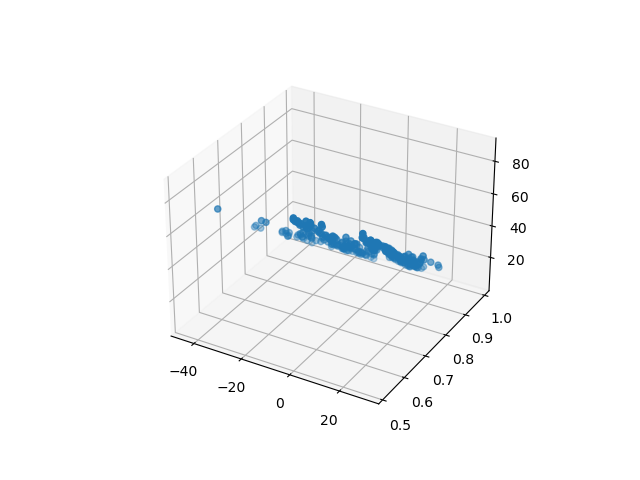

In [141]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2])
plt.show()

# Radar -> DBScan -> SORT

In [197]:
pc1.points[0:3, 0]

array([4.93104452, 0.98959228, 4.5255394 ])

In [201]:
print(pc1.points.shape)
print(points1.shape)

(18, 74)
(3, 54)


In [198]:
points1[0:3, 0]

array([1.54608054e+03, 6.55096804e+02, 1.00000000e+00])

In [199]:
int(1.54608054e+03)

1546

In [103]:
points_xyz1 = pc1.points[0:3, :].T
points_xyz1.shape

(74, 3)

In [104]:
points_xyz2 = pc2.points[0:3, :].T
points_xyz2.shape

(61, 3)

In [126]:
points_xyz = np.concatenate((pc1.points[0:3, :].T, pc2.points[0:3, :].T, pc3.points[0:3, :].T, pc4.points[0:3, :].T), axis=0)
points_xyz.shape

(282, 3)

In [127]:
points_xyz[1,:]

array([4.93191173, 0.98735175, 4.92553228])

In [467]:
cluster = DBSCAN(eps=1, min_samples=2)
output = cluster.fit(points_xyz)
output.labels_

array([-1, -1, -1,  0,  0, -1,  1, -1,  2, -1,  3, -1,  4,  5, -1, -1, -1,
       -1, -1, -1,  6,  7, -1, -1,  8, -1,  9, -1, -1, 10, -1, 11, 11, 12,
       -1, -1, -1, -1, -1, -1, 13, 13, -1, 13, -1, -1, -1, 14, -1, -1, -1,
       -1, -1, 15, -1, -1, -1, 16, 16, -1, -1, -1, -1, -1, -1, -1, 17, -1,
       -1, -1, -1, 18, -1, -1, -1,  2,  5, -1, -1, -1, -1,  6, -1,  6,  6,
        7, -1, 19,  9, 10, -1, -1, -1, -1, 20, -1, -1, -1, -1, 21, -1, -1,
       13, -1, 13, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       22, -1, -1, -1, 17, 17, -1, 23, 24, 18, -1, -1, 25, -1, -1, -1, 26,
       26,  1, -1, -1,  2, -1,  4, 27, -1, 28, -1, -1, -1, -1,  8, -1, -1,
       -1, -1, -1, -1, -1, 12, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 20,
       -1, -1, 21, -1, -1, -1, -1, 29, 14, -1, -1, -1, -1, -1, -1, 22, -1,
       17, -1, -1, -1, -1, -1, 25, -1, -1, -1, -1, 30, 30, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  3, 27, -1, 28,
       -1, -1, -1, -1, 19

In [468]:
labels = output.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of nose points: %d" % n_noise_)

Estimated number of clusters: 32
Estimated number of nose points: 208


In [469]:
set(output.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31}

In [470]:
# Abscissa is horizontal axis in a two-dimensional coordinate system, often denoted as the x-axis
# Ordinate is vertical axis in a two-dimensional coordinate system, often denoted as the y-axis
# Find abscissa and ordinate for each cluster
dets_list = []
for cluster_id in set(output.labels_):
    if cluster_id != -1:  # -1 represents noise points
        cluster_points = [point for point, label in zip(points_xyz, output.labels_) if label == cluster_id]
        x_min, x_max = min(point[0] for point in cluster_points), max(point[0] for point in cluster_points)
        y_min, y_max = min(point[1] for point in cluster_points), max(point[1] for point in cluster_points)
        z_avg = sum(point[2] for point in cluster_points)/len(cluster_points)
        # for point in cluster_points:
        #     print(point[2])
        # # z_avg = z_avg/len(cluster_points[2])
        # print(len(cluster_points))
        print(f"Cluster {cluster_id}: Abscissa ({x_min}, {x_max}), Ordinate ({y_min}, {y_max}), Z Avg ({z_avg})")
        dets_list.append([x_min, y_min, x_max, y_max])

dets_np = np.array(dets_list)

Cluster 0: Abscissa (4.337550345644862, 4.936247803060148), Ordinate (0.9722740151247741, 0.9761490781408202), Z Avg (7.2261397249076955)
Cluster 1: Abscissa (8.739272481402852, 9.53840329146444), Ordinate (0.9715641914557809, 0.9744904063585108), Z Avg (8.11638863761456)
Cluster 2: Abscissa (8.949678325268156, 10.14924223264135), Ordinate (0.9448492080944639, 0.9503587926539928), Z Avg (12.86489683284527)
Cluster 3: Abscissa (-8.24550523786549, -8.046373185997842), Ordinate (0.9177841384634623, 0.9201960953636062), Z Avg (15.153687166174851)
Cluster 4: Abscissa (10.351843144221343, 10.950973733815518), Ordinate (0.9404478150360446, 0.9432026064984147), Z Avg (13.91303906695885)
Cluster 5: Abscissa (7.354886518529117, 7.556620216214801), Ordinate (0.9257249933953747, 0.9300346419976908), Z Avg (15.919925928672418)
Cluster 6: Abscissa (-15.435946194321243, -14.437249724411174), Ordinate (0.8865325549126958, 0.8911850487609368), Z Avg (19.61820877266701)
Cluster 7: Abscissa (6.5748344317

In [379]:
dets_np.shape

(32, 4)

In [380]:
dets_np

array([[  4.33755035,   0.97227402,   4.9362478 ,   0.97614908],
       [  8.73927248,   0.97156419,   9.53840329,   0.97449041],
       [  8.94967833,   0.94484921,  10.14924223,   0.95035879],
       [ -8.24550524,   0.91778414,  -8.04637319,   0.9201961 ],
       [ 10.35184314,   0.94044782,  10.95097373,   0.94320261],
       [  7.35488652,   0.92572499,   7.55662022,   0.93003464],
       [-15.43594619,   0.88653255, -14.43724972,   0.89118505],
       [  6.57483443,   0.87781669,   7.37396524,   0.8807429 ],
       [-13.42641225,   0.86403548, -13.02771453,   0.86773912],
       [ -6.41862626,   0.84762984,  -6.41775905,   0.84987038],
       [-14.61773666,   0.84060162, -13.81860585,   0.84352783],
       [-15.81860044,   0.84086478, -15.61816756,   0.84181363],
       [  9.18870321,   0.84419661,   9.98870028,   0.84488229],
       [  5.80909139,   0.78466312,   7.20735326,   0.79431093],
       [ 11.61167752,   0.78369013,  11.81297761,   0.78687951],
       [  2.22254306,   0

In [478]:
trackers = mot_tracker.update(dets_np)
len(trackers)

31

In [479]:
for d in trackers:
    print('%d,%.2f,%.2f,%.2f,%.2f,1,-1,-1,-1'%(d[4],d[0],d[1],d[2]-d[0],d[3]-d[1]))

90,-5.11,0.58,0.60,0.00,1,-1,-1,-1
88,-35.23,0.85,0.00,0.00,1,-1,-1,-1
87,-7.84,0.89,0.20,0.00,1,-1,-1,-1
86,6.36,0.92,0.40,0.00,1,-1,-1,-1
85,8.54,0.98,0.20,0.00,1,-1,-1,-1
84,17.46,0.68,0.20,0.00,1,-1,-1,-1
83,11.05,0.70,0.80,0.00,1,-1,-1,-1
82,14.64,0.70,0.80,0.00,1,-1,-1,-1
81,15.23,0.75,0.40,0.00,1,-1,-1,-1
80,5.61,0.80,0.60,0.00,1,-1,-1,-1
79,12.80,0.83,0.80,0.00,1,-1,-1,-1
78,9.77,0.88,1.00,0.00,1,-1,-1,-1
77,17.45,0.70,0.80,0.00,1,-1,-1,-1
76,16.43,0.73,0.61,0.01,1,-1,-1,-1
75,15.82,0.77,0.20,0.00,1,-1,-1,-1
74,2.22,0.75,0.40,0.00,1,-1,-1,-1
73,11.61,0.78,0.20,0.00,1,-1,-1,-1
72,5.81,0.78,1.40,0.01,1,-1,-1,-1
71,9.19,0.84,0.80,0.00,1,-1,-1,-1
70,-15.82,0.84,0.20,0.00,1,-1,-1,-1
69,-14.62,0.84,0.80,0.00,1,-1,-1,-1
68,-6.42,0.85,0.00,0.00,1,-1,-1,-1
67,-13.43,0.86,0.40,0.00,1,-1,-1,-1
66,6.57,0.88,0.80,0.00,1,-1,-1,-1
65,-15.44,0.89,1.00,0.00,1,-1,-1,-1
64,7.35,0.93,0.20,0.00,1,-1,-1,-1
63,10.35,0.94,0.60,0.00,1,-1,-1,-1
62,-8.25,0.92,0.20,0.00,1,-1,-1,-1
61,8.95,0.94,1.20,0.01,1

In [480]:
# Extract indices of core points (non-noise points)
core_points_mask = np.zeros_like(output.labels_, dtype=bool)
core_points_mask[output.core_sample_indices_] = True

# Extract noise points
noise_points_mask = output.labels_ == -1

# Create a new variable without noise points
cleaned_data = points_xyz[core_points_mask]

# Optionally, you can store the noise points in a separate variable
noise_data = points_xyz[noise_points_mask]

# Print the cleaned data and noise points
print("Cleaned Data:")
print(cleaned_data)
print("\nNoise Points:")
print(noise_data)

Cleaned Data:
[[  4.9362478    0.97614908   6.92549596]
 [  4.33755035   0.97227402   7.52678348]
 [  9.53840329   0.97449041   7.91552689]
 [  8.94967833   0.94484921  13.11673086]
 [ -8.04637319   0.9201961   14.95347416]
 [ 10.95097373   0.94320261  13.71239389]
 [  7.55662022   0.92572499  16.31970248]
 [-15.03638127   0.88843026  19.5685335 ]
 [  6.57483443   0.87781669  24.72171385]
 [-13.42641225   0.86403548  24.16498967]
 [ -6.41775905   0.84762984  28.14977464]
 [-13.81860585   0.84352783  27.76579043]
 [-15.81860044   0.84181363  27.77011696]
 [-15.61816756   0.84086478  27.96968147]
 [  9.18870321   0.84419661  31.11597353]
 [  5.80909139   0.78862993  40.52315871]
 [  6.80908868   0.78948703  40.52099544]
 [  6.41082457   0.78466312  41.32184555]
 [ 11.61167752   0.78687951  41.71059086]
 [  2.62167485   0.75339947  46.32997579]
 [ 15.82033811   0.76807399  45.70143298]
 [ 16.02033738   0.76824541  45.70100033]
 [ 17.03507732   0.73101344  52.49871364]
 [ 18.24548141   0.7

In [481]:
cleaned_data.shape

(74, 3)

In [482]:
noise_data.shape

(208, 3)

In [228]:
points_xyz[:5, :]

array([[4.93104452, 0.98959228, 4.5255394 ],
       [4.93191173, 0.98735175, 4.92553228],
       [4.93407977, 0.98175041, 5.925514  ],
       [4.9362478 , 0.97614908, 6.92549596],
       [4.33755035, 0.97227402, 7.52678348]])

In [211]:
cleaned_data[:,0]

array([ -4.89421569,  -3.96694662,   6.65102781, -15.03638127,
         6.80908868,   6.41082457,  17.03507732,   9.94967562,
       -14.43724972, -14.63551456, -15.43594619,  13.59606224,
         6.61039024,  16.63334435,  10.14924223,  12.99432906,
        10.14794141,  12.79563061])

In [306]:
cleaned_data.shape

(114, 3)

In [483]:
cleaned_pc = pc2
cleaned_pc.points = cleaned_data.T

In [309]:
cleaned_pc

In [349]:
type(pc3.points)

numpy.ndarray

In [296]:
points_xyz_pc = pc1
points_xyz_pc.points = points_xyz
points_xyz_points, points_xyz_coloring = calibrate_radar_points(pc3)

In [495]:
cleaned_data_points, cleaned_data_coloring = calibrate_radar_points(cleaned_pc)

depth [ 7.70105104  8.29973219  8.71087779 13.90932229 15.6727242  14.51358669
 17.10615246 20.25745571 25.50357358 24.86065586 28.87548243 28.45961253
 28.45531772 28.6557377  31.908828   41.30104402 41.30319143 42.10229065
 42.51343816 47.0938739  46.52225198 46.52268146 53.32447913 58.12680891
 13.91146969 16.30576384 19.85876506 20.65829567 20.45658724 25.10531241
 25.51259268 28.47550334 28.8578737  35.31810172 39.70198663 40.50409221
 41.90273345 49.92164954 52.52366198 54.12443731 57.51911057 58.51304651
 58.52507198 62.7248572   7.30880261  8.10919075  9.10913943 13.71190963
 14.91227734 18.10438321 19.67337883 24.26154524 31.91054592 34.51685509
 39.70069818 24.61385382 43.11383532 50.52075826 51.72327432 62.32530569
 68.92496926 68.92496926 13.111941   16.07227476 17.70354421 20.27291703
 25.51044528 35.11639329 24.41386332 47.49299594 57.9113609  57.92080949
 76.47690528 76.67560352]
(3, 74)
(3, 74)
-----


In [496]:
cleaned_data_points.shape

(3, 57)

In [497]:
cleaned_data_points

array([[1.58857176e+03, 2.22046454e+02, 1.42651710e+03, 1.17505327e+03,
        1.65599262e+02, 5.62700211e+02, 2.29746609e+02, 1.40648529e+02,
        1.54194009e+02, 1.20568822e+03, 1.01227332e+03, 1.04292414e+03,
        1.02654014e+03, 1.17938009e+03, 9.01785448e+02, 1.26219201e+03,
        1.26763211e+03, 1.23346862e+03, 1.22492514e+03, 1.44106913e+03,
        1.22114196e+03, 1.38340661e+03, 5.59175798e+02, 2.02697077e+02,
        1.32561195e+03, 1.03303380e+03, 1.05995463e+03, 1.03359867e+03,
        1.22657255e+03, 1.23022566e+03, 1.22726315e+03, 1.15000920e+03,
        1.08369430e+03, 1.20481521e+03, 1.17862193e+03, 1.33676294e+03,
        3.68092092e+02, 1.70476510e+02, 1.23741592e+03, 1.31548345e+03,
        1.01390167e+03, 1.18016115e+03, 1.21164860e+03, 1.23177565e+03,
        1.18502578e+03, 1.14946238e+03, 1.14946238e+03, 2.20993703e+02,
        1.31999446e+03, 3.68774043e+02, 1.33381203e+03, 1.29970245e+03,
        8.90378430e+02, 1.06900602e+03, 1.16516770e+03, 7.486815

/tmp/ipykernel_55495/2178938055.py:3: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


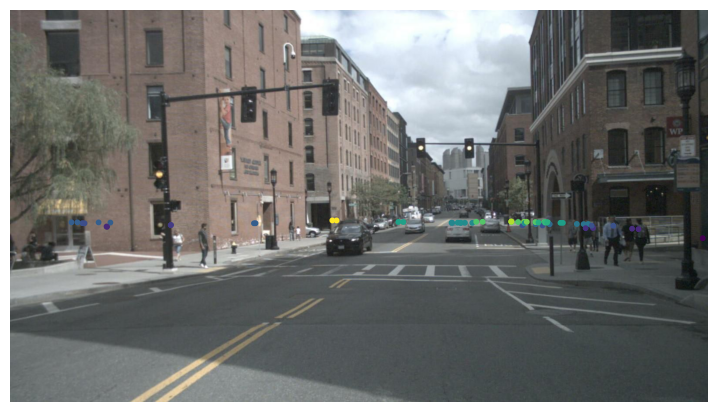

In [498]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
fig.canvas.set_window_title("sample token")
ax.imshow(im3)
ax.scatter(cleaned_data_points[0, :], cleaned_data_points[1, :], c=cleaned_data_coloring, s=10)
ax.axis('off')
plt.show()

In [146]:
points_xyz[0:5, :]

array([[4.93104452, 0.98959228, 4.5255394 ],
       [4.93191173, 0.98735175, 4.92553228],
       [4.93407977, 0.98175041, 5.925514  ],
       [4.9362478 , 0.97614908, 6.92549596],
       [4.33755035, 0.97227402, 7.52678348]])

In [144]:
len(labels)

282

In [143]:
points_xyz.shape

(282, 3)

In [137]:
points_xyz[:,1]

array([0.98959228, 0.98735175, 0.98175041, 0.97614908, 0.97227402,
       0.96561278, 0.97449041, 0.97663919, 0.94484921, 0.93408596,
       0.9201961 , 0.93605849, 0.94320261, 0.92572499, 0.92081417,
       0.91073177, 0.90219215, 0.90573161, 0.91652867, 0.88607382,
       0.88843026, 0.87781669, 0.88882379, 0.87324387, 0.86403548,
       0.88543643, 0.84762984, 0.85740562, 0.85678271, 0.84352783,
       0.83558214, 0.84181363, 0.84086478, 0.84419661, 0.83145599,
       0.8246185 , 0.85634571, 0.83635233, 0.78282578, 0.81787999,
       0.78862993, 0.78948703, 0.80049414, 0.78466312, 0.80323686,
       0.76739314, 0.76698269, 0.78687951, 0.76417961, 0.76182803,
       0.76974474, 0.77636252, 0.75710793, 0.75339947, 0.75652606,
       0.74806612, 0.73810686, 0.76807399, 0.76824541, 0.73945408,
       0.7312935 , 0.7496572 , 0.75609389, 0.71900678, 0.79169376,
       0.70552737, 0.73101344, 0.69249461, 0.75911428, 0.71343201,
       0.6783778 , 0.70515556, 0.74327602, 0.68715162, 0.96467

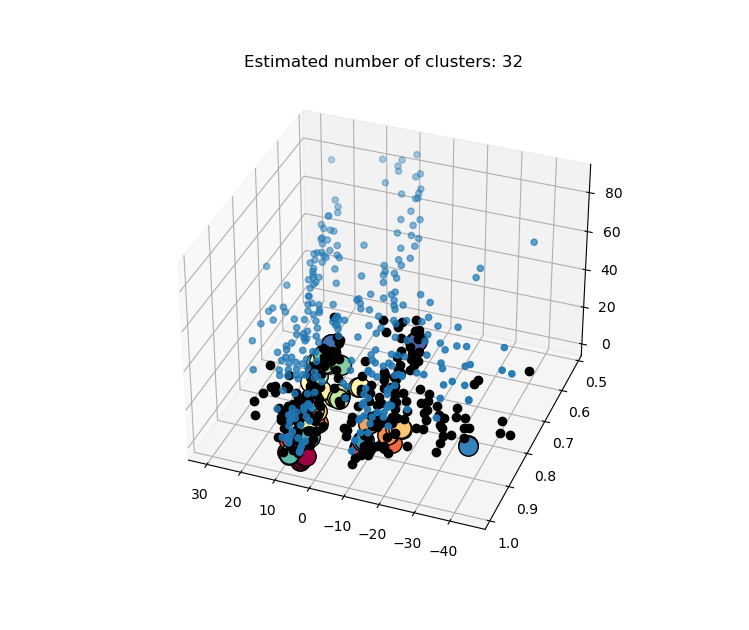

In [142]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[output.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = points_xyz[class_member_mask & core_samples_mask]

    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = points_xyz[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

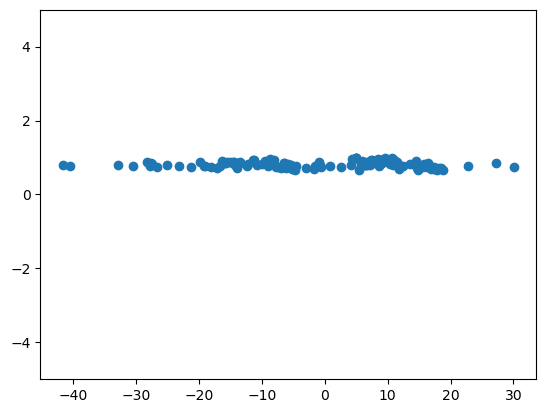

In [96]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylim([-5, 5])
ax.scatter(points_xyz[0, :], points_xyz[1, :])
plt.show()

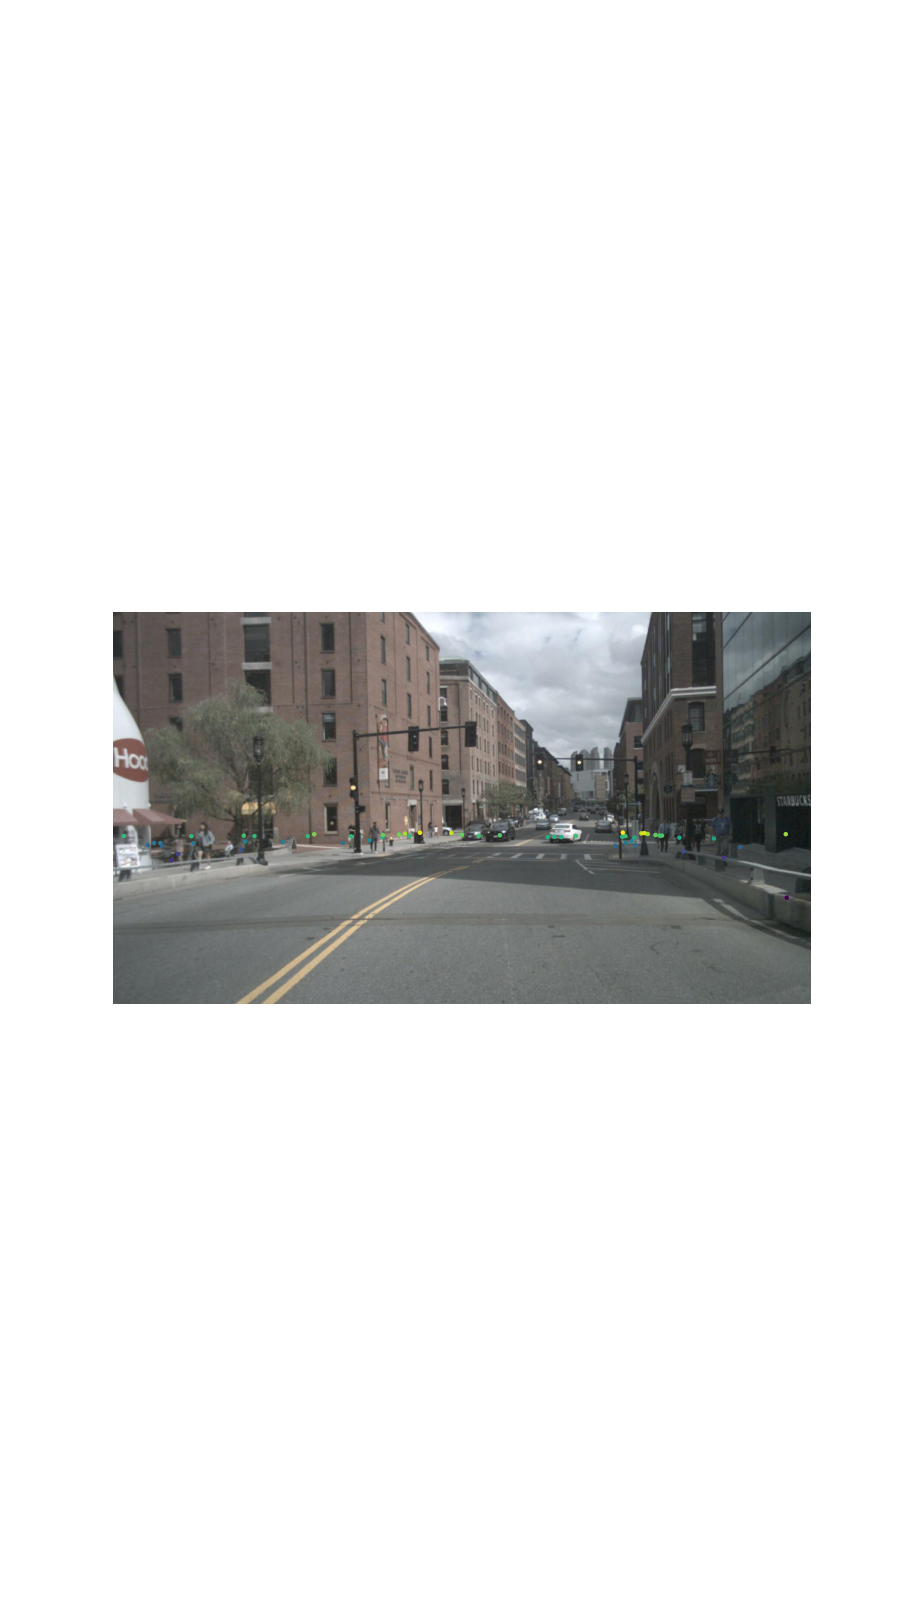

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
# fig.canvas.set_window_title("sample token")
ax.imshow(im)
ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
ax.axis('off')
plt.show()

# Widget Iterative

In [388]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [499]:
def f(x):
    print("hello")

In [500]:
%matplotlib inline
interact(f, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>

In [503]:
os.listdir(directory)

['CAM_BACK_RIGHT',
 'RADAR_BACK_RIGHT',
 'CAM_FRONT',
 'RADAR_BACK_LEFT',
 'RADAR_FRONT',
 'LIDAR_TOP',
 'CAM_FRONT_LEFT',
 'CAM_BACK',
 'CAM_BACK_LEFT',
 'CAM_FRONT_RIGHT',
 'RADAR_FRONT_RIGHT',
 'RADAR_FRONT_LEFT']

In [507]:
# Directory containing the files
directory = '/media/asus/backup/Nuscenes/data/sets/nuscenes/samples'

# Filter files based on keywords
image_files = [file for file in os.listdir(os.path.join(directory, 'CAM_FRONT'))]
pcd_files = [file for file in os.listdir(os.path.join(directory, 'RADAR_FRONT'))]





In [510]:
pcd_files

['n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402927664178.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928114656.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928719956.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402929175111.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402929699442.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402930155470.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402930680594.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402931210794.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402931660959.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402932190673.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402932641364.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402933171442.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402933626683.pcd',
 'n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402934150966.pcd',
 'n015-2018-07-24-11-22-45+0800__R

In [509]:
# Sort files by their timestamp assuming filename format: 'prefix_timestamp.extension'
image_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
pcd_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

Estimated number of clusters: 44
Estimated number of nose points: 0
Cluster 0: Abscissa (8.199999809265137, 20.799999237060547), Ordinate (2.9000000953674316, 6.5), Z Avg (0.0)
Cluster 1: Abscissa (10.0, 13.800000190734863), Ordinate (-8.300000190734863, -6.900000095367432), Z Avg (0.0)
Cluster 2: Abscissa (13.600000381469727, 14.0), Ordinate (11.899999618530273, 12.100000381469727), Z Avg (0.0)
Cluster 3: Abscissa (17.600000381469727, 18.399999618530273), Ordinate (12.699999809265137, 13.100000381469727), Z Avg (0.0)
Cluster 4: Abscissa (22.0, 23.600000381469727), Ordinate (-7.699999809265137, -7.699999809265137), Z Avg (0.0)
Cluster 5: Abscissa (17.600000381469727, 19.0), Ordinate (20.299999237060547, 20.700000762939453), Z Avg (0.0)
Cluster 6: Abscissa (26.600000381469727, 26.600000381469727), Ordinate (-7.900000095367432, -7.900000095367432), Z Avg (0.0)
Cluster 7: Abscissa (16.0, 17.0), Ordinate (24.100000381469727, 25.5), Z Avg (0.0)
Cluster 8: Abscissa (31.0, 31.0), Ordinate (-5

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  r = w / float(h)
/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:86: RuntimeWarning: invalid value encountered in multiply
  w = np.sqrt(x[2] * x[3])
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


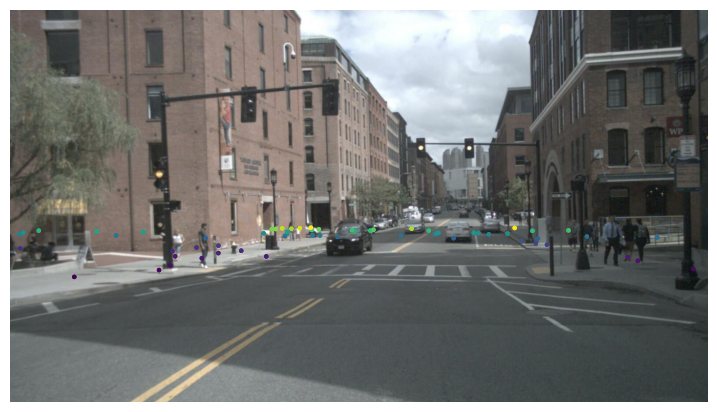

Estimated number of clusters: 80
Estimated number of nose points: 0
Cluster 0: Abscissa (-6.439005809646573, -2.8446525473805613), Ordinate (0.8793401590157285, 0.950602648931741), Z Avg (16.20131079492666)
Cluster 1: Abscissa (6.946648965768091, 8.347078878029139), Ordinate (0.9300346419976908, 0.9510565483989522), Z Avg (13.320080608911017)
Cluster 2: Abscissa (-12.04549514131254, -11.844627705917043), Ordinate (0.9124580452683272, 0.9145271561051477), Z Avg (15.561900468172274)
Cluster 3: Abscissa (-13.03682028691833, -12.635086369799017), Ordinate (0.8871264956065963, 0.8912647180976286), Z Avg (19.763771460913652)
Cluster 4: Abscissa (7.772662955562004, 7.7761318152744), Ordinate (0.8754844041300753, 0.8844465412387863), Z Avg (24.519121727892575)
Cluster 5: Abscissa (-20.6337648431149, -20.236799650810102), Ordinate (0.8769088874172568, 0.8850935949198608), Z Avg (20.080207084854035)
Cluster 6: Abscissa (7.982635670349873, 7.982635670349873), Ordinate (0.8588518214183711, 0.85885

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


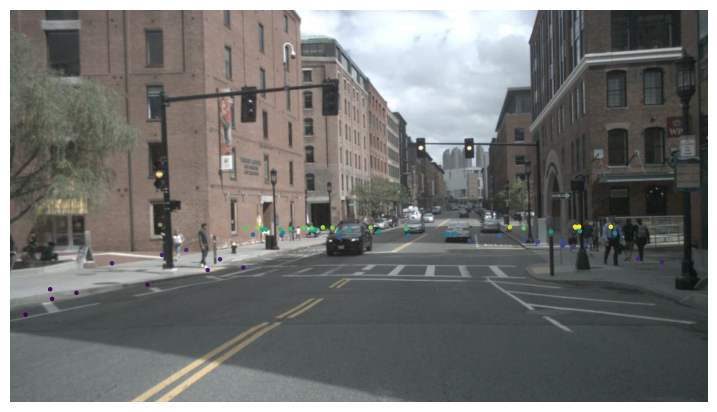

Estimated number of clusters: 127
Estimated number of nose points: 0
Cluster 0: Abscissa (-0.9286054171471152, -0.8483704538153874), Ordinate (-21.514549907984875, -8.91763857797139), Z Avg (-3.3052705645234757)
Cluster 1: Abscissa (-0.90102258711111, -0.8759852492544223), Ordinate (-14.560818289451339, -10.759544218538148), Z Avg (9.063577033558596)
Cluster 2: Abscissa (-0.9026720760319235, -0.899829867633306), Ordinate (-14.69478741511815, -14.294110729837952), Z Avg (-10.29387594879975)
Cluster 3: Abscissa (-0.8781772917759578, -0.8724928762270318), Ordinate (-19.09191827978485, -18.290564912504053), Z Avg (-11.2083481733887)
Cluster 4: Abscissa (-0.822563636538894, -0.8122420784621619), Ordinate (-24.361931861971296, -22.761974279646022), Z Avg (9.374965735931688)
Cluster 5: Abscissa (-0.8876028447215858, -0.879095129929593), Ordinate (-19.664392052303075, -18.265805416051567), Z Avg (-18.809330788166747)
Cluster 6: Abscissa (-0.792627340350961, -0.792627340350961), Ordinate (-27.3

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


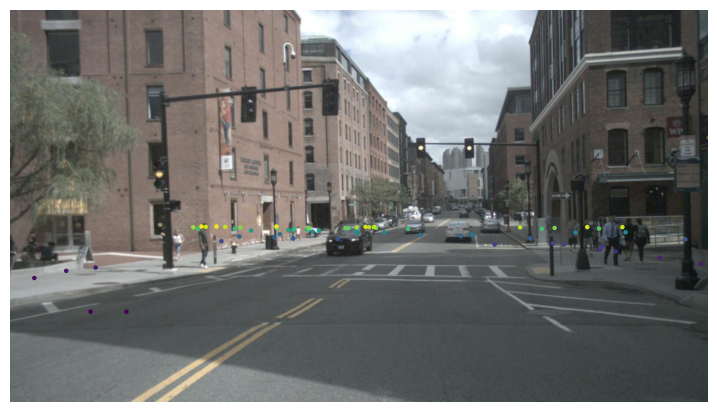

Estimated number of clusters: 151
Estimated number of nose points: 0
Cluster 0: Abscissa (8.93756793063267, 23.0), Ordinate (2.2132798204530024, 14.100000381469727), Z Avg (0.6630765880361882)
Cluster 1: Abscissa (8.199999809265137, 19.200000762939453), Ordinate (-9.699999809265137, -5.900000095367432), Z Avg (0.30742759490228194)
Cluster 2: Abscissa (14.308320279747303, 14.709169870314255), Ordinate (11.21311339149855, 11.411403234587052), Z Avg (0.6890226207167637)
Cluster 3: Abscissa (22.793040368096285, 24.393011336131845), Ordinate (-8.352379956652694, -8.345551020464194), Z Avg (0.8153014174586839)
Cluster 4: Abscissa (18.27309654432784, 19.67135577534351), Ordinate (19.62832322577418, 20.034292692087107), Z Avg (0.9172223237236992)
Cluster 5: Abscissa (27.200000762939453, 27.393813509298134), Ordinate (-10.100000381469727, -8.532743366435366), Z Avg (0.5538717102942833)
Cluster 6: Abscissa (16.656836451182155, 17.650816814613222), Ordinate (23.421425365298063, 24.82566725316064)

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: divide by zero encountered in scalar divide
  r = w / float(h)
/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:86: RuntimeWarning: invalid value encountered in multiply
  w = np.sqrt(x[2] * x[3])
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


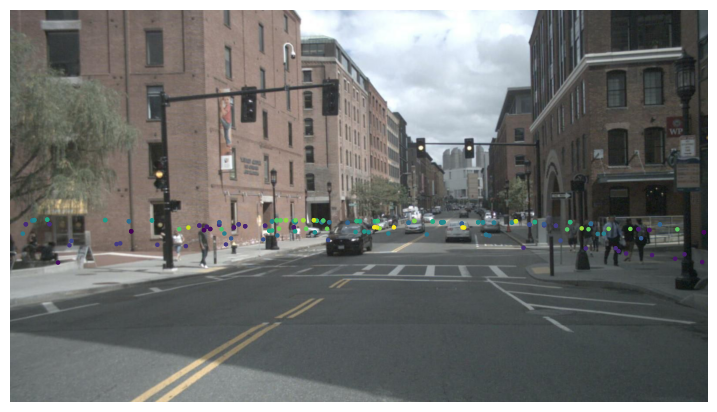

Estimated number of clusters: 190
Estimated number of nose points: 0
Cluster 0: Abscissa (-14.03248150613075, -2.155617578146009), Ordinate (-0.000340635511304817, 0.8805521696836562), Z Avg (18.68172120068776)
Cluster 1: Abscissa (5.966597613193802, 9.757914890524042), Ordinate (0.14794359623956108, 0.9620877971618758), Z Avg (15.28324401782246)
Cluster 2: Abscissa (-11.354636806845825, -11.155477715131223), Ordinate (0.04737879727556913, 0.9096115023732125), Z Avg (16.283529510511016)
Cluster 3: Abscissa (8.424092370726179, 8.427446669694257), Ordinate (0.0528619455978568, 0.06872079799030677), Z Avg (25.30616091895209)
Cluster 4: Abscissa (-19.965824752585082, -19.562894411573772), Ordinate (-0.04736373148371842, -0.03143343394175134), Z Avg (20.74583500825092)
Cluster 5: Abscissa (8.617800250287317, 10.183930823562582), Ordinate (0.024153506396792465, 0.8573766401830573), Z Avg (29.042214077890623)
Cluster 6: Abscissa (-24.761556777648217, -23.359482405052024), Ordinate (-0.0521857

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


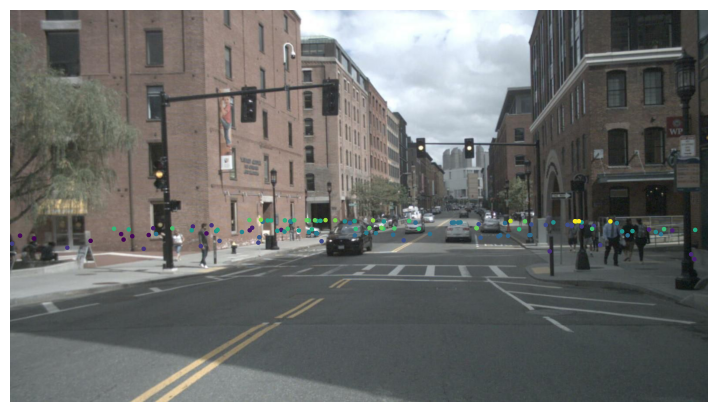

Estimated number of clusters: 226
Estimated number of nose points: 0
Cluster 0: Abscissa (-0.8665844520398848, 0.023254426945326857), Ordinate (-23.697297722962972, -9.6524155699264), Z Avg (-4.813291733415965)
Cluster 1: Abscissa (-0.911063412294268, -0.09173708207596058), Ordinate (-19.955860066936893, -8.963718761216454), Z Avg (9.875106196363987)
Cluster 2: Abscissa (-0.8951738196951701, -0.03266497936169066), Ordinate (-15.400737678050877, -14.999222494701328), Z Avg (-9.607080100735239)
Cluster 3: Abscissa (-0.004755461047309393, 0.012447955786897186), Ordinate (-25.15185616497786, -23.5519959641134), Z Avg (10.020144107184619)
Cluster 4: Abscissa (0.03094593670607231, 0.04718479157641338), Ordinate (-20.332073028282, -18.9352972875765), Z Avg (-18.144140929071746)
Cluster 5: Abscissa (-0.7858767236350991, 0.044111419659098), Ordinate (-28.153143932637718, -27.970089114142258), Z Avg (10.713793283686096)
Cluster 6: Abscissa (0.025008272181588072, 0.039910943083419276), Ordinate (

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


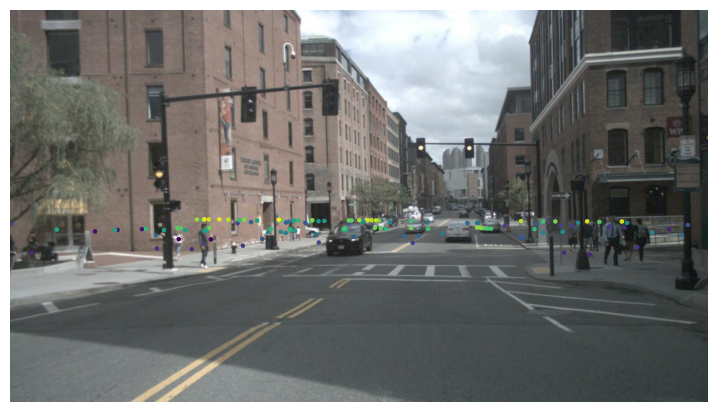

Estimated number of clusters: 259
Estimated number of nose points: 0
Cluster 0: Abscissa (9.674705919417487, 25.799999237060547), Ordinate (1.5262084206028386, 13.436974860938472), Z Avg (1.2492330655719022)
Cluster 1: Abscissa (8.995008514859405, 19.985376706701363), Ordinate (-10.699999809265137, -6.5), Z Avg (0.9826724310081582)
Cluster 2: Abscissa (15.015887143583608, 15.41757565775241), Ordinate (10.525544144482083, 10.722123197324036), Z Avg (1.5504504090841509)
Cluster 3: Abscissa (23.585380995883938, 25.185263725244774), Ordinate (-9.004870432060237, -8.991242580033338), Z Avg (1.6312117357719815)
Cluster 4: Abscissa (17.0, 20.34160269382256), Ordinate (18.100000381469727, 19.367483268015082), Z Avg (1.4675572221800772)
Cluster 5: Abscissa (28.00323340522842, 33.79999923706055), Ordinate (-11.133161776448791, -8.699999809265137), Z Avg (0.9380478410019515)
Cluster 6: Abscissa (17.312612159458673, 18.300510515653357), Ordinate (22.741679901483156, 24.150093667856183), Z Avg (1.8

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


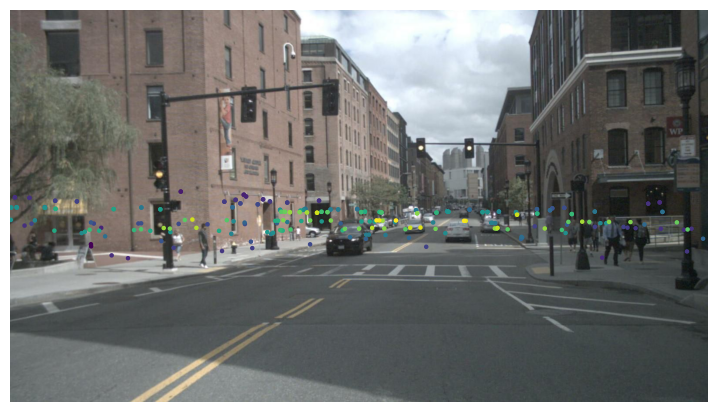

Estimated number of clusters: 282
Estimated number of nose points: 0
Cluster 0: Abscissa (-13.367184450269809, -1.4662325722348921), Ordinate (-0.8879507609923133, 0.9027740169752871), Z Avg (19.950390167746963)
Cluster 1: Abscissa (6.55445488659231, 10.76138104098801), Ordinate (-0.634582846092227, 0.930469227175265), Z Avg (16.148200816416505)
Cluster 2: Abscissa (-10.663097154975587, -10.465646291993007), Ordinate (-0.8177793464709889, 0.04451242375701114), Z Avg (16.98593774570847)
Cluster 3: Abscissa (9.0721921563745, 9.082339696683906), Ordinate (-0.770379594657415, -0.7475952623790693), Z Avg (26.092467287315376)
Cluster 4: Abscissa (-19.296785706652827, -18.038107573923067), Ordinate (-0.9716400912956903, 0.8903400179609129), Z Avg (20.88331261124215)
Cluster 5: Abscissa (8.789137328913695, 11.22892173806195), Ordinate (-0.8465480465109458, 0.842733498562778), Z Avg (32.20691648420895)
Cluster 6: Abscissa (-24.083788092901266, -22.677537388143524), Ordinate (-0.98824679157946, 

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


len of trackers 3
497,8.78,-0.61,2.46,1.36,1,-1,-1,-1
492,-6.19,-0.76,10.07,1.36,1,-1,-1,-1
344,7.52,-10.91,9.24,3.87,1,-1,-1,-1
Cleaned Data:
[[-3.82929163 -0.67319138 11.41004847]
 [-2.83823582 -0.68373452 12.81635527]
 [-3.04583326 -0.7027014  14.014914  ]
 ...
 [62.40000153 41.09999847  0.        ]
 [72.40000153 22.29999924  0.        ]
 [62.59999847 43.29999924  0.        ]]

Noise Points:
[]
depth [ -2.1584214   -1.17528606  -1.38963653  10.01881421  11.4162805
  -1.41837748   9.99007326   0.17188355  -2.42785871  10.37326815
  -1.64709844  -1.26390401  -3.45889566  -9.02241492  -8.82722413
  -3.4900317   -3.10923186 -10.07021742  -9.67983679  10.67502987
  10.65586922 -17.26950279  10.8199235  -17.68623024 -21.04996674
 -22.46180302   7.96750902  12.77421832  -6.62625396   0.93946182
  -2.67934208   5.10311936  -0.49872066  20.94466556  -1.1082417
  17.32107112 -14.4925425   12.0521293    8.04294532  -3.55590557
   8.41416437  -5.77963817  14.21598491  12.0042277    8.79017403
 

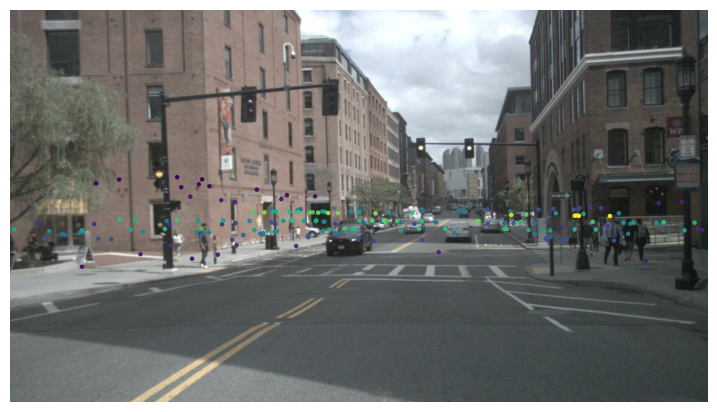

Estimated number of clusters: 303
Estimated number of nose points: 0
Cluster 0: Abscissa (-0.8784391124830128, 0.9066690704489527), Ordinate (-26.49997311781357, -10.386762925732798), Z Avg (-4.328461418566748)
Cluster 1: Abscissa (-0.8783227265527123, 0.6929460722942784), Ordinate (-20.738286609079964, -9.756306043291007), Z Avg (10.537435353067815)
Cluster 2: Abscissa (-0.027992496249376917, 0.8345796345616407), Ordinate (-16.10592568660565, -15.703583123917827), Z Avg (-8.92303388805386)
Cluster 3: Abscissa (0.8136426726982783, 0.8377567277788354), Ordinate (-25.94101838064351, -24.341314469656346), Z Avg (10.665449545731082)
Cluster 4: Abscissa (-0.8885934015121331, 0.9734698975627274), Ordinate (-20.998648894073416, -17.67338648322828), Z Avg (-17.26326642409766)
Cluster 5: Abscissa (-0.7722271401184905, 0.9243579646713346), Ordinate (-34.5692232753521, -28.77014839273009), Z Avg (11.5756842568587)
Cluster 6: Abscissa (0.9528032218538576, 0.9779821579787112), Ordinate (-18.9410102

/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:77: RuntimeWarning: invalid value encountered in scalar divide
  r = w / float(h)
/home/asus/zzzzz/ros2/acceleration_robotics/research_thesis/colcon_ws/src/carla-multi-sensor-fusion/deepsort_tracking/deepsort_tracking/sort.py:87: RuntimeWarning: invalid value encountered in divide
  h = x[2] / w
/tmp/ipykernel_55495/3999194264.py:64: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("sample token")


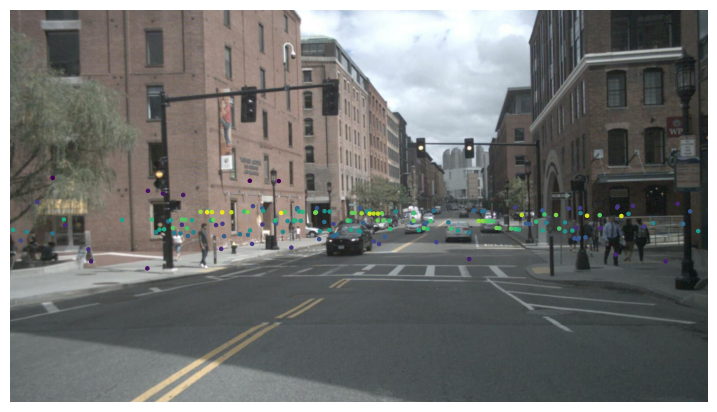

KeyboardInterrupt: Interrupted by user

In [522]:
# Reading files sequentially
for image_file, pcd_file in zip(image_files, pcd_files):
    image_path = os.path.join(directory, 'CAM_FRONT', image_file)
    pcd_path = os.path.join(directory, 'RADAR_FRONT',pcd_file)

    # Reading image
    image = Image.open(image_path)
    # Do something with the image

    # Reading pcd file
    pc = RadarPointCloud.from_file(pcd_path)
    # Do something with the radar point cloud data

    process_radar
    # Example: Print filenames
    # print("Image:", image_path)
    # print("PCD:", pcd_path)

    # Example: Close the image object
    # image.close()

In [515]:
previous_pc = RadarPointCloud.from_file('/media/asus/backup/Nuscenes/data/sets/nuscenes/samples/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402927664178.pcd')

In [516]:
dbscan = DBSCAN(eps=1, min_samples=2)

In [521]:

def process_radar(current_pc : RadarPointCloud, im: Image):
    global previous_pc
    # step 1: check if previous frame radar data is available
    # step 2: combine the points from the previous and current frame of radar data
    points_xyz = np.concatenate((previous_pc.points[0:3, :].T, current_pc.points[0:3, :].T), axis=0)
    # step 3: db scan to find the clusters
    output = db_scan.fit(points_xyz)
    labels = output.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of nose points: %d" % n_noise_)

    # step 4: find the cluster detections
    # Abscissa is horizontal axis in a two-dimensional coordinate system, often denoted as the x-axis
    # Ordinate is vertical axis in a two-dimensional coordinate system, often denoted as the y-axis
    # Find abscissa and ordinate for each cluster
    dets_list = []
    for cluster_id in set(output.labels_):
        if cluster_id != -1:  # -1 represents noise points
            cluster_points = [point for point, label in zip(points_xyz, output.labels_) if label == cluster_id]
            x_min, x_max = min(point[0] for point in cluster_points), max(point[0] for point in cluster_points)
            y_min, y_max = min(point[1] for point in cluster_points), max(point[1] for point in cluster_points)
            z_avg = sum(point[2] for point in cluster_points)/len(cluster_points)
            # for point in cluster_points:
            #     print(point[2])
            # # z_avg = z_avg/len(cluster_points[2])
            # print(len(cluster_points))
            print(f"Cluster {cluster_id}: Abscissa ({x_min}, {x_max}), Ordinate ({y_min}, {y_max}), Z Avg ({z_avg})")
            dets_list.append([x_min, y_min, x_max, y_max])

    dets_np = np.array(dets_list)
    trackers = mot_tracker.update(dets_np)
    print("len of trackers", len(trackers))

    for d in trackers:
        print('%d,%.2f,%.2f,%.2f,%.2f,1,-1,-1,-1'%(d[4],d[0],d[1],d[2]-d[0],d[3]-d[1]))
    
    # step 5: getting the core points from the clusters
    # Extract indices of core points (non-noise points)
    core_points_mask = np.zeros_like(output.labels_, dtype=bool)
    core_points_mask[output.core_sample_indices_] = True

    # Extract noise points
    noise_points_mask = output.labels_ == -1

    # Create a new variable without noise points
    cleaned_data = points_xyz[core_points_mask]

    # Optionally, you can store the noise points in a separate variable
    noise_data = points_xyz[noise_points_mask]

    # Print the cleaned data and noise points
    print("Cleaned Data:")
    print(cleaned_data)
    print("\nNoise Points:")
    print(noise_data)
    cleaned_data_pc = current_pc
    cleaned_data_pc.points = cleaned_data.T
    cleaned_data_points, cleaned_data_coloring = calibrate_radar_points(cleaned_data_pc)
    # %matplotlib inline
    fig, ax = plt.subplots(1, 1, figsize=(9, 16))
    fig.canvas.set_window_title("sample token")
    ax.imshow(im3)
    ax.scatter(cleaned_data_points[0, :], cleaned_data_points[1, :], c=cleaned_data_coloring, s=5)
    ax.axis('off')
    plt.show()
    previous_pc = current_pc
    input("waiting for next frame")
